# **Studying Mass segregation for Coma Berenices**

### **Importing Coma Berenices (Comber) data**

Libraries imported and some parameters adjusted for plots.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', size=20)  #fontsize for plots
plt.rc('axes', titlesize=30)#fontsize of the title

# pd.set_option('display.max_row', None) # Display more rows, but eats a lot of ram

A function to transform the apparent magnitudes to absolute magnitudes is defined. Since we know the distance between the Sun and the object ($44\, kpc$), this is simple.

In [2]:
def app_2_abs(app, d=32_000):
    output = app - 5 * np.log10(d / 10)
    return output

Data is imported as a dataframe, some cleaning is done (double quotes removed) and then columns of interest are created.

In [3]:
# Data is imported
df = pd.read_csv("umaii_calib_cut.csv", header=5, sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')  # sep is in that way to skip any number of whitespaces.

# Double quotes are removed
df.rename(columns = {'"id':'id', 'ar"':'ar'}, inplace = True)
df['id'] = df['id'].apply(lambda x : str(x.strip('"')))  # id's will be strings
df['ar'] = df['ar'].apply(lambda x : float(x.strip('"')))

# Column with G-R 
df.insert(7, 'g-r', df.g - df.r, True)

# Column with absolute magnitudes
df.insert(3, 'G', df.g.apply(app_2_abs), True)
df.insert(6, 'R', df.r.apply(app_2_abs), True)

In [4]:
df

,id,ra,dec,G,g,gerr,R,r,rerr,g-r,chi,sharp,rd,l,b,egr,ag,ar
0,10100003,12.447312,23.907527,6.100637,24.3179,0.0195,5.635037,23.8523,0.0136,0.4656,1.0030,-0.0490,1.846,241.707,83.585,0.0180,0.0655,0.0475
1,10100005,12.447323,23.892127,6.912437,25.1297,0.0368,6.059237,24.2765,0.0205,0.8532,1.0546,0.6885,2.350,241.825,83.577,0.0177,0.0646,0.0468
2,10100006,12.447303,23.923080,7.808937,26.0262,0.1231,7.797737,26.0150,0.0691,0.0112,0.9873,-0.5051,1.732,241.587,83.593,0.0182,0.0662,0.0480
3,10100009,12.447394,23.794176,3.662337,21.8796,0.0035,3.439337,21.6566,0.0037,0.2230,1.0722,-0.0589,7.677,242.570,83.526,0.0174,0.0634,0.0460
4,10100010,12.447456,23.721257,7.056037,25.2733,0.0780,6.612637,24.8299,0.0692,0.4434,1.0343,-0.2550,11.981,243.117,83.487,0.0187,0.0680,0.0493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468368,43202664,12.415582,23.991854,6.210037,24.4273,0.1016,6.724237,24.9415,0.1078,-0.5142,1.2900,-0.1455,28.156,239.159,83.251,0.0213,0.0774,0.0562
468369,43202668,12.415611,23.953061,5.993937,24.2112,0.0872,5.938337,24.1556,0.0841,0.0556,1.5450,0.3005,27.866,239.448,83.233,0.0212,0.0773,0.0561
468370,43202680,12.415555,23.992610,5.272537,23.4898,0.0499,5.461137,23.6784,0.0461,-0.1886,1.6085,-0.1065,28.185,239.152,83.251,0.0213,0.0774,0.0561
468371,43202680,12.415469,24.071748,5.229137,23.4464,0.0423,5.362337,23.5796,0.0466,-0.1332,1.5130,0.2070,29.372,238.555,83.288,0.0202,0.0736,0.0534


Some first ideas:
* Since there are objects with more than 1 detection, the **mean** of each column for each object will be taken so we have a dataframe with unique id's. According to Ricardo, this is not true, and the reason for having repeated id's is a previous problem related to assigning id's. The line to take the mean was `df_mean = df.groupby('id').apply(lambda df_aux: df_aux.mean()).reset_index(drop=True)`
* Add column with colors (difference between bands: g-r)

### **Color Magnitud Diagram (CMD)**

For this section, the entirety of the dataframe is used.

Two functions are created:
* `plot_cmd`: Makes a plot of the CMD, with no filter at all
* `plot_cmd_radius`: Makes a plot of the CMD, separating two regions by a radius (parameter that needs to be given)

In [5]:
def plot_cmd(df):
    fig, ax = plt.subplots(figsize=(10,9))
    
    ax.scatter(df['g-r'], df['G'], s=.05, c='k')
    ax.set_title('CMD')
    ax.set_ylabel('G')
    ax.set_xlabel('G-R')
    ax.set_ylim(ax.get_ylim()[::-1])


def plot_cmd_radius(df, radius):
    inner_mask = df.rd <= radius

    df_inner = df.loc[inner_mask]
    x_inner = df_inner['g-r']
    y_inner = df_inner['G']
    
    df_outer = df.loc[~inner_mask]
    x_outer = df_outer['g-r']
    y_outer = df_outer['G']

    fig, axs = plt.subplots(1, 2, figsize=(20,9))

    axs[0].scatter(x_inner, y_inner, s=.05, c='k')
    axs[1].scatter(x_outer, y_outer, s=.05, c='k')
    axs[0].set_title('CMD for $r\leq$' + str(radius))
    axs[1].set_title('CMD for $r>$' + str(radius))
    
    for ax in axs:
        ax.set_ylabel('G')
        ax.set_xlabel('G-R')
        ax.set_ylim(ax.get_ylim()[::-1])

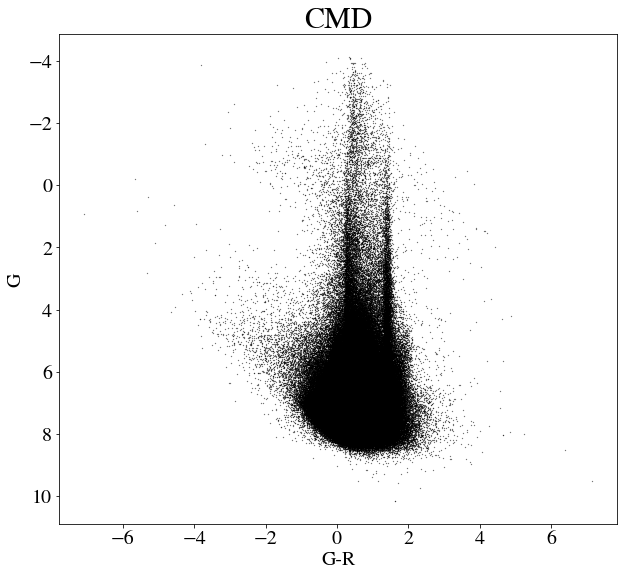

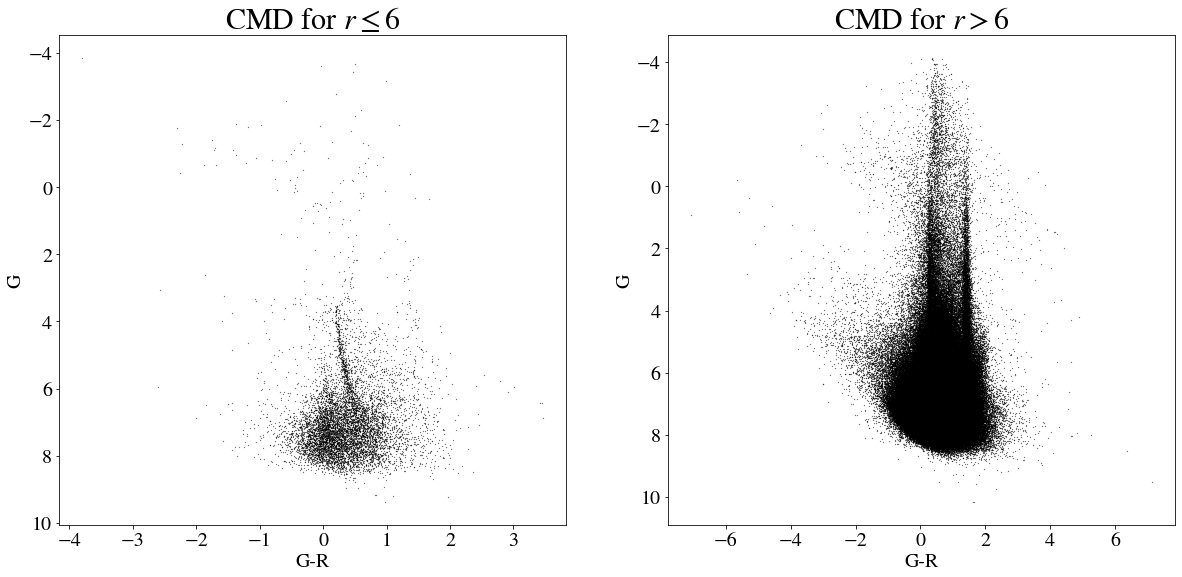

In [6]:
plot_cmd(df)
plot_cmd_radius(df, 6)

### **Exploring parameters**

Since the target is to select the stars of the object (cluster or galaxy), the parameters "$\chi$" and "sharp" are of interest. 

* Sharp: If I trust my memory, this parameter gives us information about the shape of the object.
* Chi: I don't remember :c


In [7]:
def plot_sharp(df):
    fig, axs = plt.subplots(1, 2, figsize=(20,9))
    
    axs[0].scatter(df.G, df['sharp'], s=.05, c='k')
    axs[1].scatter(df.R, df['sharp'], s=.05, c='k')

    axs[0].set_title('G vs Sharp')
    axs[1].set_title('R vs Sharp')

    axs[0].set_ylabel('G')
    axs[1].set_ylabel('R')
    
    axs[0].set_xlabel('Sharp')
    axs[1].set_xlabel('Sharp')


def plot_chi(df):
    fig, axs = plt.subplots(1, 2, figsize=(20,9))
    
    axs[0].scatter(df.G, df['chi'], s=.05, c='k')
    axs[1].scatter(df.R, df['chi'], s=.05, c='k')

    axs[0].set_title(r'G vs $\chi$')
    axs[1].set_title(r'R vs $\chi$')

    axs[0].set_ylabel('G')
    axs[1].set_ylabel('R')
    
    axs[0].set_xlabel(r'$\chi$')
    axs[1].set_xlabel(r'$\chi$')

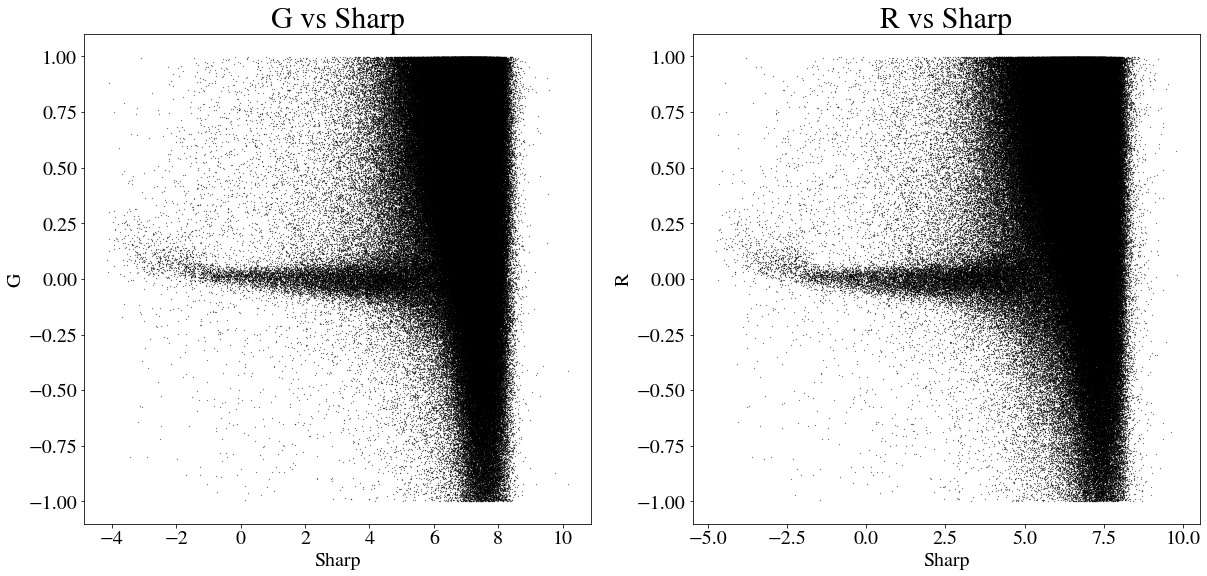

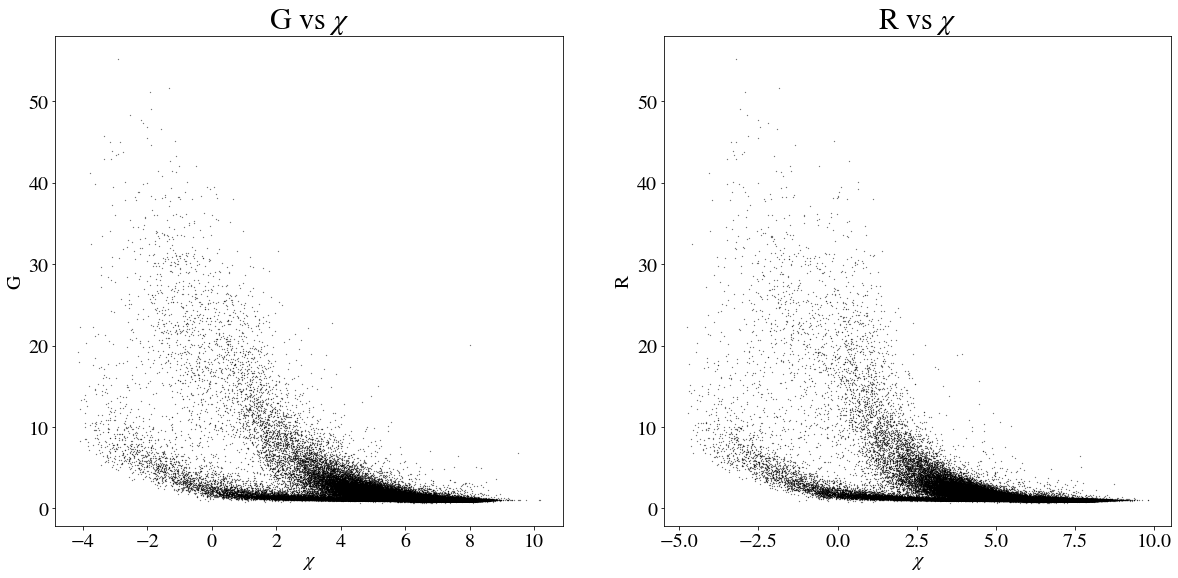

In [8]:
plot_sharp(df)
plot_chi(df)

### **Filtered CMD**

In the following cells, only the objects with values of sharp and chi minor than 0.25 and 1.3 respectively, will be considered as a proper star. 

In [9]:
mask = (np.abs(df.sharp) < .25) & (df.chi < 1.3)
df_filtered = df.loc[mask]

df_filtered

,id,ra,dec,G,g,gerr,R,r,rerr,g-r,chi,sharp,rd,l,b,egr,ag,ar
0,10100003,12.447312,23.907527,6.100637,24.3179,0.0195,5.635037,23.8523,0.0136,0.4656,1.0030,-0.0490,1.846,241.707,83.585,0.0180,0.0655,0.0475
3,10100009,12.447394,23.794176,3.662337,21.8796,0.0035,3.439337,21.6566,0.0037,0.2230,1.0722,-0.0589,7.677,242.570,83.526,0.0174,0.0634,0.0460
12,10100034,12.447364,23.933602,6.968137,25.1854,0.0494,6.230637,24.4479,0.0355,0.7375,1.1522,0.0008,1.877,241.510,83.599,0.0183,0.0666,0.0483
14,10100036,12.447370,23.931447,4.975037,23.1923,0.0074,4.668637,22.8859,0.0061,0.3064,1.0427,0.0078,1.817,241.527,83.598,0.0183,0.0665,0.0482
15,10100039,12.447413,23.875267,6.511037,24.7283,0.0239,5.135437,23.3527,0.0091,1.3756,1.0441,-0.1346,3.095,241.959,83.569,0.0174,0.0632,0.0459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468350,43202576,12.415910,23.958836,6.976237,25.1935,0.1375,6.734237,24.9515,0.1198,0.2420,1.2010,0.0125,27.648,239.423,83.239,0.0213,0.0776,0.0562
468352,43202580,12.415903,23.951389,6.133137,24.3504,0.0759,6.376037,24.5933,0.0803,-0.2429,1.1960,-0.0815,27.619,239.477,83.235,0.0213,0.0774,0.0561
468354,43202588,12.415923,23.882000,6.225237,24.4425,0.0604,5.625837,23.8431,0.0481,0.5994,1.1565,-0.1870,27.625,239.989,83.201,0.0209,0.0761,0.0552
468361,43202624,12.415663,24.058544,6.229837,24.4471,0.0748,6.249737,24.4670,0.0724,-0.0199,1.1470,0.0410,28.982,238.665,83.285,0.0204,0.0742,0.0538


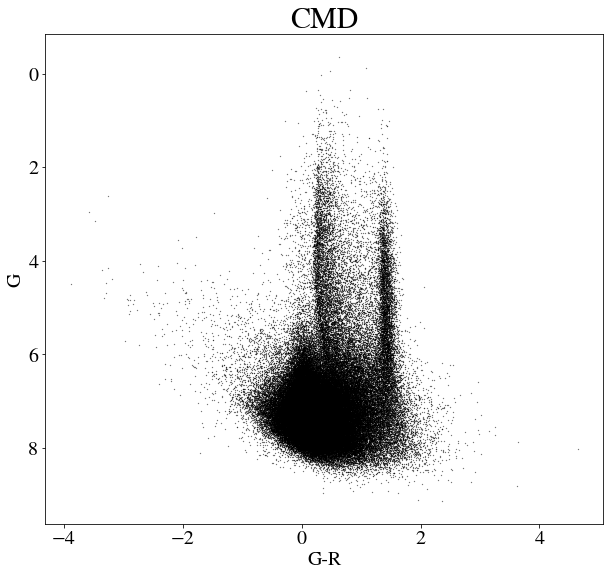

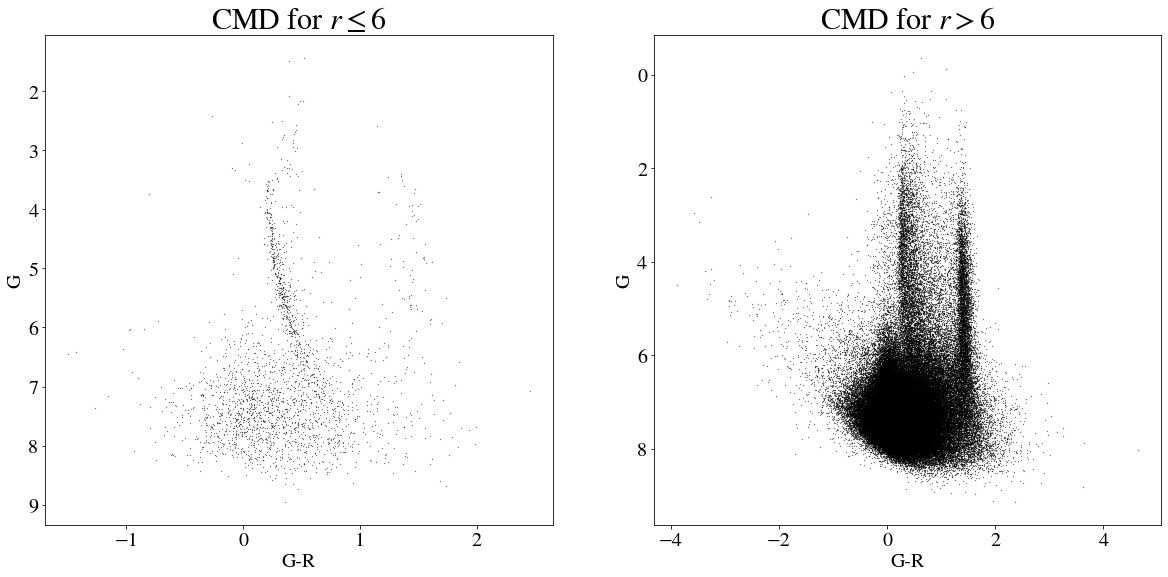

In [10]:
plot_cmd(df_filtered)
plot_cmd_radius(df_filtered, 6)

### **Matching isochrones to CMD**

Data from isochrones was obtained in the [Dartmouth](http://stellar.dartmouth.edu/models/isolf_new.html) website.

In [11]:
# Data is imported into dataframes
df_iso12 = pd.read_csv("Isochrones/isochrone12.txt", header=8, sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
df_iso125 = pd.read_csv("Isochrones/isochrone125.txt", header=8, sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
df_iso13 = pd.read_csv("Isochrones/isochrone13.txt", header=8, sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
df_iso135 = pd.read_csv("Isochrones/isochrone135.txt", header=8, sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')
df_iso14 = pd.read_csv("Isochrones/isochrone14.txt", header=8, sep="\s+|\t+|\s+\t+|\t+\s+", engine='python')

In [12]:
# G-R columns are inserted into the dataframe
df_iso12.insert(10, 'g-r', df_iso12.sdss_g - df_iso12.sdss_r, True)
df_iso125.insert(10, 'g-r', df_iso125.sdss_g - df_iso125.sdss_r, True)
df_iso13.insert(10, 'g-r', df_iso13.sdss_g - df_iso13.sdss_r, True)
df_iso135.insert(10, 'g-r', df_iso135.sdss_g - df_iso135.sdss_r, True)
df_iso14.insert(10, 'g-r', df_iso14.sdss_g - df_iso14.sdss_r, True)

In [13]:
def isochrone_cmd(df_cmd, df_iso):
    x_cmd = df_cmd['g-r']
    y_cmd = df_cmd['G']
    
    x_iso = df_iso['g-r']
    y_iso = df_iso['sdss_g']

    fig, ax = plt.subplots(figsize=(10,9))
    ax.scatter(x_cmd, y_cmd, s=.05, c='k')
    ax.plot(x_iso, y_iso, c='r')
    ax.set_title('CMD')
    ax.set_ylabel('G')
    ax.set_xlabel('G-R')
    ax.set_ylim(ax.get_ylim()[::-1])

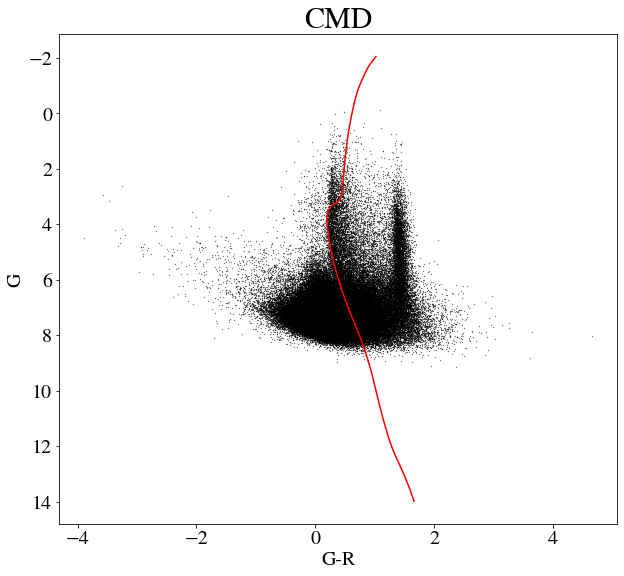

In [14]:
isochrone_cmd(df_filtered, df_iso13)

#### Considering radius

Since we are interested in the stars that are at a certain distance of the object, we consider the stars with a radius minor than 10 arcmin.

In [15]:
def isochrone_cmd_radius(df, df_iso, radius):
    inner_mask = df.rd <= radius

    df_inner = df.loc[inner_mask]
    x_inner = df_inner['g-r']
    y_inner = df_inner['G']
    
    df_outer = df.loc[~inner_mask]
    x_outer = df_outer['g-r']
    y_outer = df_outer['G']

    x_iso = df_iso['g-r']
    y_iso = df_iso['sdss_g']

    iso_name = [x for x in globals() if globals()[x] is df_iso][0][6:]

    fig, axs = plt.subplots(1, 2, figsize=(20,9))
    axs[0].scatter(x_inner, y_inner, s=1.5, c='k', label='Objects')
    axs[1].scatter(x_outer, y_outer, s=1.5, c='k', label='Objects')
    
    if len(iso_name) < 3:
        axs[0].plot(x_iso, y_iso, c='r', label='Isochrone ' + iso_name[:2] + 'Gyr')
        axs[1].plot(x_iso, y_iso, c='r', label='Isochrone ' + iso_name[:2] + 'Gyr')
    else:
        axs[0].plot(x_iso, y_iso, c='r', label='Isochrone ' + iso_name[:2]  + '.5Gyr')
        axs[1].plot(x_iso, y_iso, c='r', label='Isochrone ' + iso_name[:2] + '.5Gyr')
    
    axs[0].hlines(3.8, -0.5, 2, colors='g', label='Turn-off at G=3.8')
    axs[1].hlines(3.8, -0.5, 2, colors='g', label='Turn-off at G=3.8')
    
    axs[0].set_title('CMD for $r\leq$' + str(radius))
    axs[1].set_title('CMD for $r>$' + str(radius))

    for ax in axs:
        ax.set_ylabel('G')
        ax.set_xlabel('G-R')
        ax.set_xlim((-.5, 2))
        ax.set_ylim((-2, 8))
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.legend();

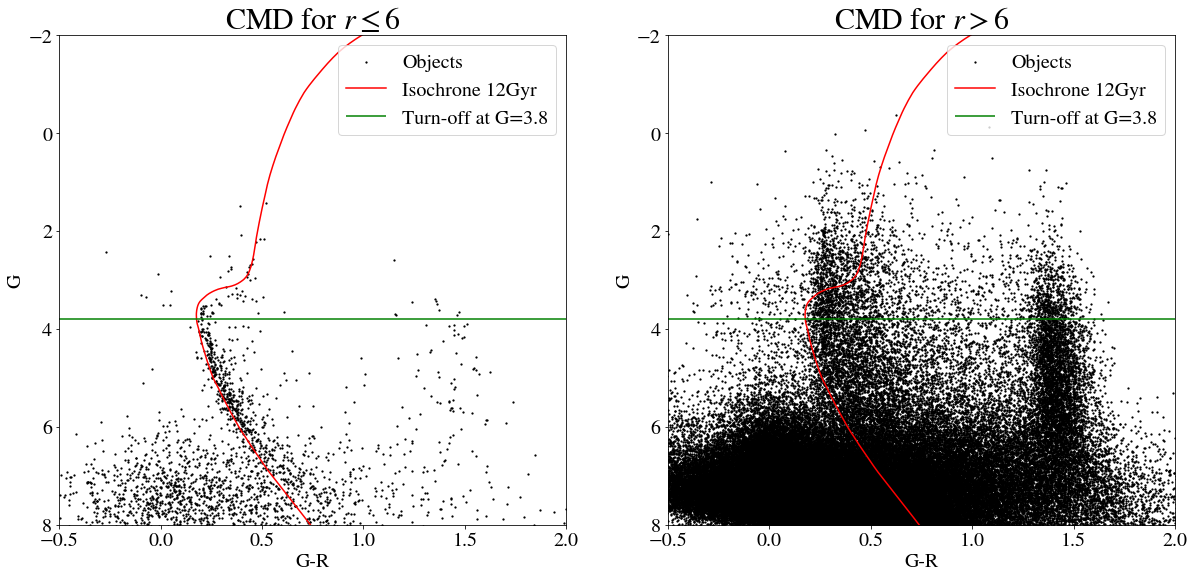

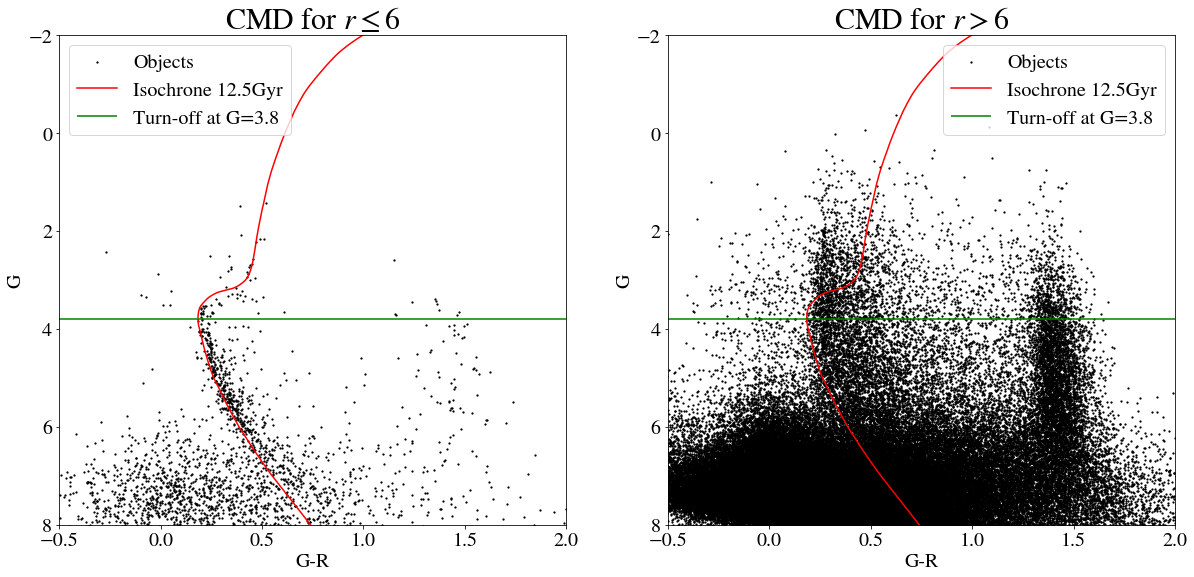

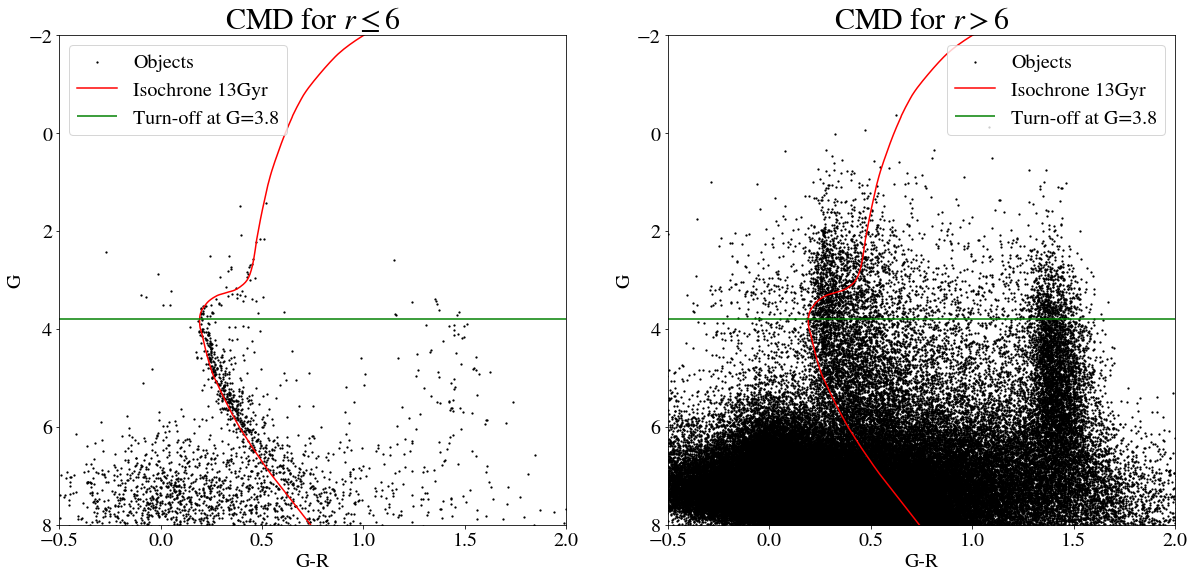

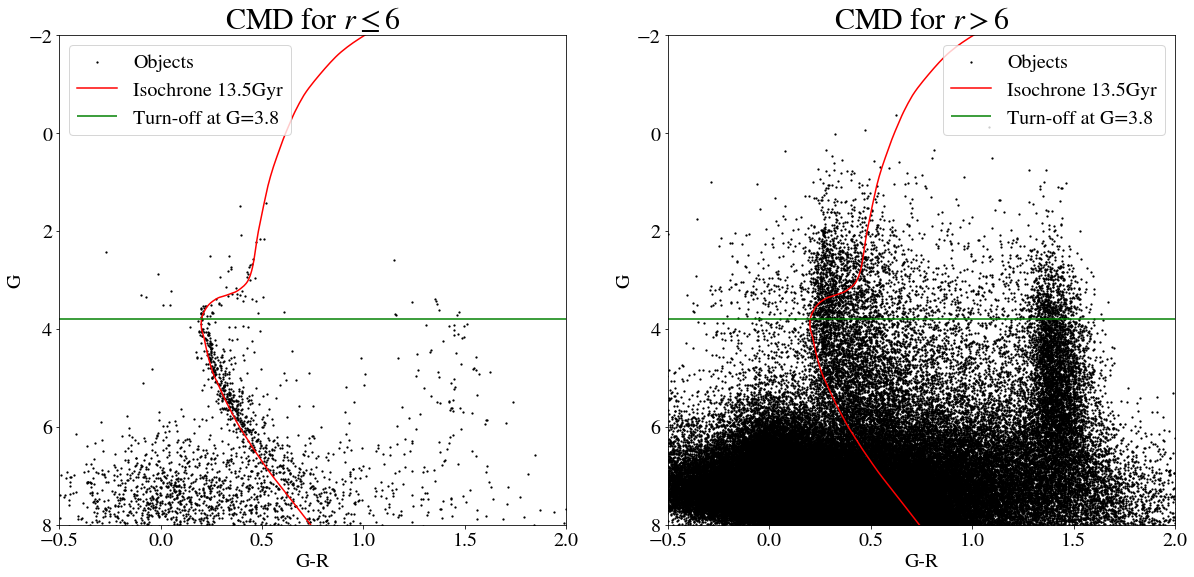

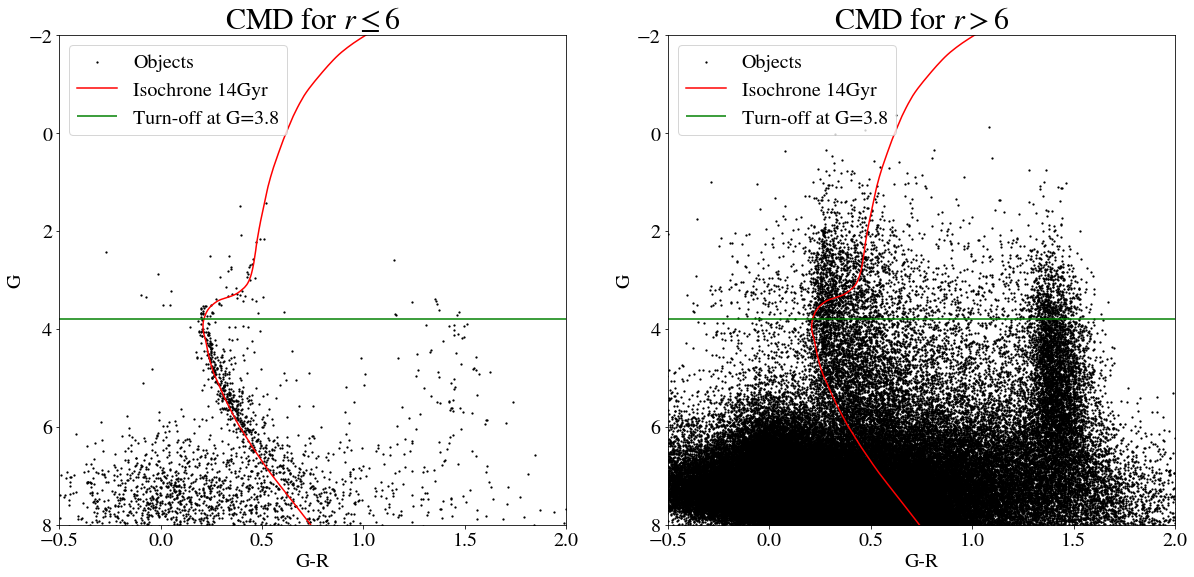

In [16]:
inner_radius = 6

isochrone_cmd_radius(df_filtered, df_iso12, inner_radius)
isochrone_cmd_radius(df_filtered, df_iso125, inner_radius)
isochrone_cmd_radius(df_filtered, df_iso13, inner_radius)
isochrone_cmd_radius(df_filtered, df_iso135, inner_radius)
isochrone_cmd_radius(df_filtered, df_iso14, inner_radius)

### **Selecting stars**

The idea is to give width to the isocrhone fo age 12 (to my eye, this seems to be the best ''fit''), so any object inside this region will be considered (a priori) as a star.

To find the distances between any star and the isochrone, we only need 2 columns for each dataframe, since we will be using euclidean distance.
The idea that I got, was to build a region based on two traslations of the isochrone curve. Then, evaluate which points (stars) are inside said region. To build the region, the shapely and descartes libraries were used; in order to build the region properly, first a traslation to the left was made (by 0.035 "color units") and a traslation to the right (by 0.185), but the latter needed to be reversed, since the libraries considers the order in which we present the points.


In [17]:
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from descartes import PolygonPatch

df_left = df_iso13.copy()
df_right = df_iso13.copy()

df_left['g-r'] = df_left['g-r'] - 0.045
df_right['g-r'] = df_right['g-r'] + 0.095

df_left = df_left[['g-r', 'sdss_g']]
df_right = df_right[['g-r', 'sdss_g']]

df_aux = pd.concat([df_left, df_right[::-1]], ignore_index=True)

In [18]:
tuples = df_aux.to_numpy()
tuples = tuple(map(tuple, tuples))

pol = Polygon(tuples)
pol_patch = PolygonPatch(pol, facecolor='pink', alpha=0.3)


def show_region(df, df_iso):
    
    x_data = df['g-r']
    y_data = df['G']

    x_iso = df_iso['g-r']
    y_iso = df_iso['sdss_g']

    fig, ax = plt.subplots(figsize=(10,9))

    ax.scatter(x_data, y_data, s=1.5, c='k')#, alpha=0.1)
    ax.scatter(x_iso, y_iso, s=2, c='r')
    ax.add_patch(pol_patch)

    ax.set_title('CMD for $r\leq 6$')
    ax.set_ylabel('G')
    ax.set_xlabel('G-R')

    ax.set_xlim((-.5, 2))
    ax.set_ylim((-2, 8))
    ax.set_ylim(ax.get_ylim()[::-1])

c:\Users\vikap\anaconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


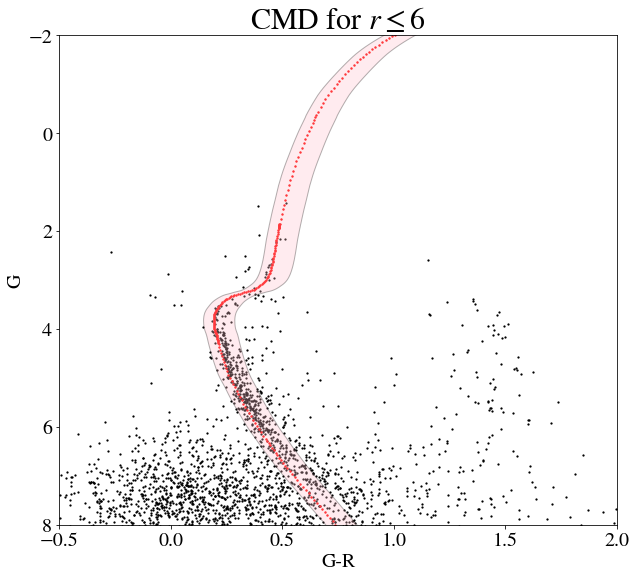

In [19]:
show_region(df_filtered.loc[df_filtered.rd <= 6], df_iso13)

Now that we got the region, let's get the points inside said region.

In [20]:
np_points = df_filtered[['g-r', 'G']].to_numpy()

check_in = []

for i in range(df_filtered.shape[0]):
    is_in = pol.contains(Point(np_points[i]))
    check_in.append(is_in)

df_filtered.insert(df_filtered.shape[1], 'inside', check_in, True)

In [21]:
df_filtered = df_filtered.loc[df_filtered.rd <= 18]
df_filtered

,id,ra,dec,G,g,gerr,R,r,rerr,g-r,chi,sharp,rd,l,b,egr,ag,ar,inside
0,10100003,12.447312,23.907527,6.100637,24.3179,0.0195,5.635037,23.8523,0.0136,0.4656,1.0030,-0.0490,1.846,241.707,83.585,0.0180,0.0655,0.0475,True
3,10100009,12.447394,23.794176,3.662337,21.8796,0.0035,3.439337,21.6566,0.0037,0.2230,1.0722,-0.0589,7.677,242.570,83.526,0.0174,0.0634,0.0460,True
12,10100034,12.447364,23.933602,6.968137,25.1854,0.0494,6.230637,24.4479,0.0355,0.7375,1.1522,0.0008,1.877,241.510,83.599,0.0183,0.0666,0.0483,False
14,10100036,12.447370,23.931447,4.975037,23.1923,0.0074,4.668637,22.8859,0.0061,0.3064,1.0427,0.0078,1.817,241.527,83.598,0.0183,0.0665,0.0482,True
15,10100039,12.447413,23.875267,6.511037,24.7283,0.0239,5.135437,23.3527,0.0091,1.3756,1.0441,-0.1346,3.095,241.959,83.569,0.0174,0.0632,0.0459,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456006,43110428,12.427853,23.965342,7.240137,25.4574,0.0909,7.166137,25.3834,0.0779,0.0740,0.9970,-0.0400,17.934,240.069,83.385,0.0218,0.0792,0.0574,False
456015,43110500,12.427808,23.895301,7.742137,25.9594,0.1395,7.637637,25.8549,0.1289,0.1045,1.0165,0.2070,17.814,240.590,83.349,0.0240,0.0874,0.0634,False
456018,43110524,12.427816,23.960944,6.961037,25.1783,0.0768,7.194937,25.4122,0.0832,-0.2339,1.0300,0.0575,17.925,240.100,83.382,0.0219,0.0798,0.0579,False
456020,43110544,12.427785,23.883851,7.650337,25.8676,0.1387,7.665637,25.8829,0.1323,-0.0153,1.0325,-0.1100,17.901,240.674,83.343,0.0242,0.0881,0.0639,False


In [22]:
df_stars = df_filtered.loc[df_filtered['inside'] == True].reset_index(drop=True)
df_stars

,id,ra,dec,G,g,gerr,R,r,rerr,g-r,chi,sharp,rd,l,b,egr,ag,ar,inside
0,10100003,12.447312,23.907527,6.100637,24.3179,0.0195,5.635037,23.8523,0.0136,0.4656,1.0030,-0.0490,1.846,241.707,83.585,0.0180,0.0655,0.0475,True
1,10100009,12.447394,23.794176,3.662337,21.8796,0.0035,3.439337,21.6566,0.0037,0.2230,1.0722,-0.0589,7.677,242.570,83.526,0.0174,0.0634,0.0460,True
2,10100036,12.447370,23.931447,4.975037,23.1923,0.0074,4.668637,22.8859,0.0061,0.3064,1.0427,0.0078,1.817,241.527,83.598,0.0183,0.0665,0.0482,True
3,10100054,12.447539,23.728166,7.303537,25.5208,0.0853,6.609937,24.8272,0.0685,0.6936,1.0383,0.0808,11.561,243.072,83.492,0.0185,0.0673,0.0488,True
4,10100095,12.447428,23.970477,5.377237,23.5945,0.0131,4.992737,23.2100,0.0089,0.3845,1.0174,0.0486,3.476,241.231,83.619,0.0186,0.0677,0.0491,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,43101320,12.431208,24.055572,6.640637,24.8579,0.0514,6.116637,24.3339,0.0324,0.5240,1.0175,-0.1345,17.051,239.583,83.469,0.0189,0.0688,0.0499,True
1452,43104184,12.430222,23.853073,7.092437,25.3097,0.0892,6.509637,24.7269,0.0598,0.5828,0.9485,0.0110,16.261,241.050,83.356,0.0243,0.0885,0.0642,True
1453,43104208,12.430261,24.012727,7.783337,26.0006,0.1281,7.098337,25.3156,0.0743,0.6850,0.9950,0.0680,16.709,239.854,83.437,0.0203,0.0740,0.0537,True
1454,43106680,12.429302,23.984123,8.054837,26.2721,0.1826,7.294537,25.5118,0.0862,0.7603,1.0085,0.1330,16.981,240.014,83.411,0.0214,0.0777,0.0564,True


Now, objects with very low brightness (apparent magnitude greater than 24.5) will be dropped.

In [23]:
df_stars = df_stars.loc[df_stars.g < 24.5].reset_index(drop=True)

In [24]:
df_stars

,id,ra,dec,G,g,gerr,R,r,rerr,g-r,chi,sharp,rd,l,b,egr,ag,ar,inside
0,10100003,12.447312,23.907527,6.100637,24.3179,0.0195,5.635037,23.8523,0.0136,0.4656,1.0030,-0.0490,1.846,241.707,83.585,0.0180,0.0655,0.0475,True
1,10100009,12.447394,23.794176,3.662337,21.8796,0.0035,3.439337,21.6566,0.0037,0.2230,1.0722,-0.0589,7.677,242.570,83.526,0.0174,0.0634,0.0460,True
2,10100036,12.447370,23.931447,4.975037,23.1923,0.0074,4.668637,22.8859,0.0061,0.3064,1.0427,0.0078,1.817,241.527,83.598,0.0183,0.0665,0.0482,True
3,10100095,12.447428,23.970477,5.377237,23.5945,0.0131,4.992737,23.2100,0.0089,0.3845,1.0174,0.0486,3.476,241.231,83.619,0.0186,0.0677,0.0491,True
4,10100102,12.447453,23.946883,5.370737,23.5880,0.0113,5.078237,23.2955,0.0086,0.2925,1.0032,-0.2446,2.303,241.414,83.607,0.0184,0.0670,0.0486,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,43023072,12.433569,24.003721,5.808437,24.0257,0.0260,5.448837,23.6661,0.0187,0.3596,1.0610,0.0215,13.970,240.120,83.472,0.0212,0.0772,0.0560,True
763,43025104,12.433041,24.022491,4.738337,22.9556,0.0111,4.451637,22.6689,0.0082,0.2867,1.1050,0.1910,14.810,239.945,83.475,0.0203,0.0740,0.0537,True
764,43026280,12.432770,24.057369,5.502637,23.7199,0.0205,5.117337,23.3346,0.0141,0.3853,1.0935,-0.0810,15.991,239.662,83.489,0.0191,0.0695,0.0504,True
765,43026312,12.432737,24.007479,3.024837,21.2421,0.0030,2.626537,20.8438,0.0029,0.3983,1.2180,0.0110,14.689,240.041,83.464,0.0211,0.0770,0.0558,True


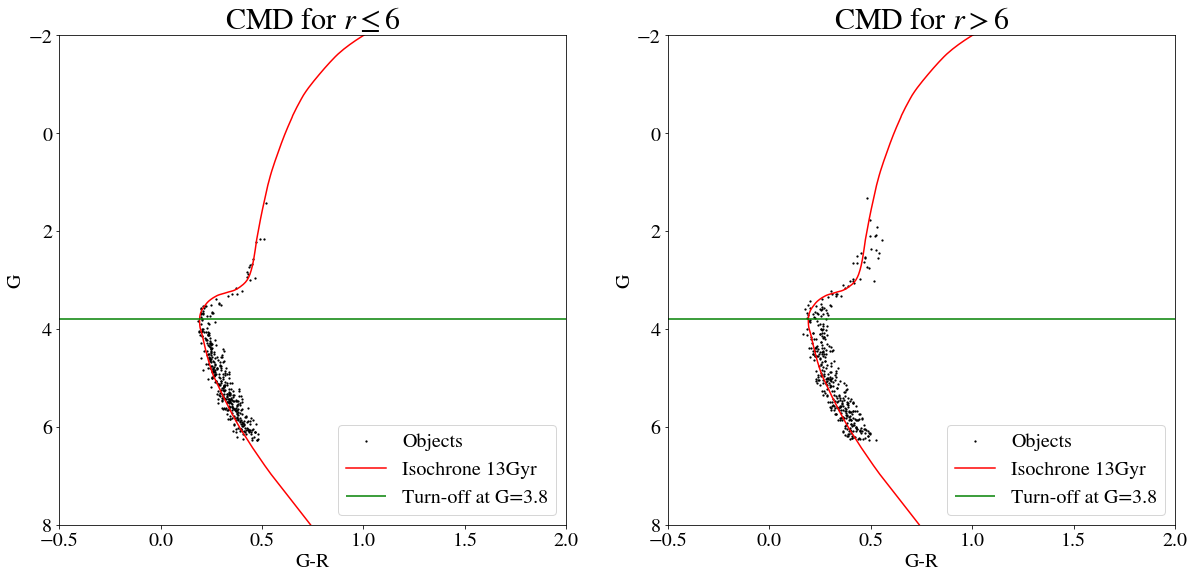

In [25]:
isochrone_cmd_radius(df_stars, df_iso13, inner_radius)

In [26]:
minrd = df_stars.loc[df_stars.rd < 0.1]

In [27]:
df_stars

,id,ra,dec,G,g,gerr,R,r,rerr,g-r,chi,sharp,rd,l,b,egr,ag,ar,inside
0,10100003,12.447312,23.907527,6.100637,24.3179,0.0195,5.635037,23.8523,0.0136,0.4656,1.0030,-0.0490,1.846,241.707,83.585,0.0180,0.0655,0.0475,True
1,10100009,12.447394,23.794176,3.662337,21.8796,0.0035,3.439337,21.6566,0.0037,0.2230,1.0722,-0.0589,7.677,242.570,83.526,0.0174,0.0634,0.0460,True
2,10100036,12.447370,23.931447,4.975037,23.1923,0.0074,4.668637,22.8859,0.0061,0.3064,1.0427,0.0078,1.817,241.527,83.598,0.0183,0.0665,0.0482,True
3,10100095,12.447428,23.970477,5.377237,23.5945,0.0131,4.992737,23.2100,0.0089,0.3845,1.0174,0.0486,3.476,241.231,83.619,0.0186,0.0677,0.0491,True
4,10100102,12.447453,23.946883,5.370737,23.5880,0.0113,5.078237,23.2955,0.0086,0.2925,1.0032,-0.2446,2.303,241.414,83.607,0.0184,0.0670,0.0486,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,43023072,12.433569,24.003721,5.808437,24.0257,0.0260,5.448837,23.6661,0.0187,0.3596,1.0610,0.0215,13.970,240.120,83.472,0.0212,0.0772,0.0560,True
763,43025104,12.433041,24.022491,4.738337,22.9556,0.0111,4.451637,22.6689,0.0082,0.2867,1.1050,0.1910,14.810,239.945,83.475,0.0203,0.0740,0.0537,True
764,43026280,12.432770,24.057369,5.502637,23.7199,0.0205,5.117337,23.3346,0.0141,0.3853,1.0935,-0.0810,15.991,239.662,83.489,0.0191,0.0695,0.0504,True
765,43026312,12.432737,24.007479,3.024837,21.2421,0.0030,2.626537,20.8438,0.0029,0.3983,1.2180,0.0110,14.689,240.041,83.464,0.0211,0.0770,0.0558,True


In [28]:
def ra_vs_dec(df_cmd):
    x_cmd = df_cmd['ra']
    y_cmd = df_cmd['dec']

    fig, ax = plt.subplots(figsize=(10,9))
    
    ax.scatter(x_cmd, y_cmd, s=1.5, c='k')
    ax.scatter(df_cmd.loc[df_cmd.rd < 12].ra, df_cmd.loc[df_cmd.rd < 12].dec, s=1.5, c='r')
    ax.scatter(df_cmd.loc[df_cmd.rd < 6].ra, df_cmd.loc[df_cmd.rd < 6].dec, s=1.5, c='blue')

    ax.set_title('Spatial representation')
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')

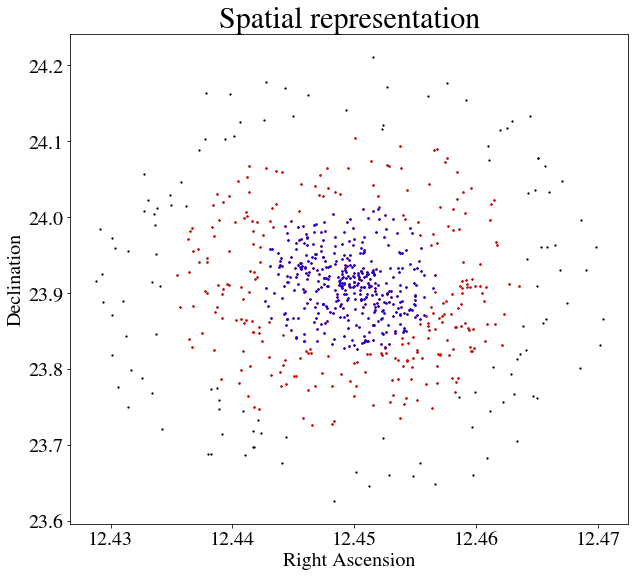

In [29]:
ra_vs_dec(df_stars)

### **Finding the radius where the same amount of objects are inside and outside**

This was done by trial and error.

In [30]:
r_same = 6

df_stars.shape[0] / 2 - df_stars.loc[df_stars.rd <= r_same].shape[0]

-4.5

In [31]:
df_stars.loc[df_stars.rd <= r_same]

,id,ra,dec,G,g,gerr,R,r,rerr,g-r,chi,sharp,rd,l,b,egr,ag,ar,inside
0,10100003,12.447312,23.907527,6.100637,24.3179,0.0195,5.635037,23.8523,0.0136,0.4656,1.0030,-0.0490,1.846,241.707,83.585,0.0180,0.0655,0.0475,True
2,10100036,12.447370,23.931447,4.975037,23.1923,0.0074,4.668637,22.8859,0.0061,0.3064,1.0427,0.0078,1.817,241.527,83.598,0.0183,0.0665,0.0482,True
3,10100095,12.447428,23.970477,5.377237,23.5945,0.0131,4.992737,23.2100,0.0089,0.3845,1.0174,0.0486,3.476,241.231,83.619,0.0186,0.0677,0.0491,True
4,10100102,12.447453,23.946883,5.370737,23.5880,0.0113,5.078237,23.2955,0.0086,0.2925,1.0032,-0.2446,2.303,241.414,83.607,0.0184,0.0670,0.0486,True
5,10100125,12.447551,23.847688,4.231537,22.4488,0.0046,4.006937,22.2242,0.0044,0.2246,1.0468,-0.0614,4.548,242.177,83.556,0.0172,0.0626,0.0454,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,42810272,12.451577,23.837640,4.323137,22.5404,0.0151,4.049437,22.2667,0.0131,0.2737,1.0900,-0.0920,5.213,242.515,83.598,0.0162,0.0590,0.0428,True
733,42810316,12.451581,23.858258,4.918937,23.1362,0.0162,4.580537,22.7978,0.0128,0.3384,1.0800,-0.0160,4.076,242.359,83.609,0.0165,0.0600,0.0435,True
734,42812048,12.451096,23.836757,5.787137,24.0044,0.0582,5.422937,23.6402,0.0360,0.3642,1.0390,0.0315,5.140,242.490,83.591,0.0163,0.0593,0.0430,True
735,42824180,12.447439,23.885588,4.077537,22.2948,0.0073,3.840137,22.0574,0.0063,0.2374,1.0820,0.0027,2.575,241.882,83.575,0.0176,0.0640,0.0464,True


In [32]:
print("Objects with radius minor than " + str(r_same)+"'' : ", len(df_stars.loc[df_stars.rd <= r_same]),
"\n" "Objects with radius greater than " + str(r_same)+"'' : ", len(df_stars.loc[df_stars.rd > r_same]))

Objects with radius minor than 6'' :  388 
Objects with radius greater than 6'' :  379


So, for a radius of 34.9 arcmin, there are the same number of objects inside and outside said radius.

### **Building Light and Mass Functions (LF's & MF's)**

#### Table 3

The objective to obtain the table 3 from [Lee et. al.](https://arxiv.org/abs/astro-ph/0409037). The values for the incompleteness correction factors were obtained from [Muñoz et. al.](https://arxiv.org/abs/0910.3946).

With R. Muñoz we concluded that considering a value of 1.0 for the incompleteness correction factors will be a close approximation.

The idea is to create bins containing a range of size 1 for apparent magnitudes, and check how many stars will be inside that range. Then, they are separated based on the distance to the center of the satellite.

**Important** Only stars with magnitude greater than $G ~ 3.8$ will be considered, since this is the Turn-off and the Mass Luminosity relations is valid for stars in the main sequence.

In [33]:
df_filt_stars = df_stars.loc[df_stars.G > 3.8]

In [34]:
N_in = np.zeros(18, dtype=int)
N_mid = np.zeros(18, dtype=int)
N_out = np.zeros(18, dtype=int)
app_mag_bins = np.arange(15, 24, 0.5)

for idx, mag in enumerate(app_mag_bins):
    low, up = mag, mag + 1
    mask = (df_filt_stars.g >= low) & (df_filt_stars.g < up)
    N_in[idx] += len(df_filt_stars.loc[mask & (df_filt_stars.rd <= 6)])
    N_mid[idx] += len(df_filt_stars.loc[mask & ((df_filt_stars.rd > 6) & (df_filt_stars.rd <= 12))])
    N_out[idx] += len(df_filt_stars.loc[mask & (df_filt_stars.rd > 12)])


In [35]:
mag_bins = []

for idx, mag in enumerate(app_mag_bins):
    str_mag = str(round(mag, 3))
    str_mag1 = str(round(mag + 0.5, 3))
    mag_bins.append(str_mag+'-'+str_mag1)

In [36]:
columns1 = ['Inside', 'Middle', 'Outside', 'Global']
columns2 = ['N', 'f']
columns = pd.MultiIndex.from_product([columns1, columns2])

In [37]:
data_in = np.array(list(zip(N_in, np.ones(18))), dtype='float')
data_mid = np.array(list(zip(N_mid, np.ones(18))), dtype='float')
data_out = np.array(list(zip(N_out, np.ones(18))), dtype='float')
data_gen = np.array(list(zip(N_in + N_out, np.ones(18))), dtype='float')

In [38]:
df_tbl3 = pd.DataFrame(columns=columns, index=mag_bins)
df_tbl3.index.name = 'g'

df_tbl3['Inside'] = data_in
df_tbl3['Middle'] = data_mid
df_tbl3['Outside'] = data_out
df_tbl3['Global'] = data_gen

In [39]:
df_tbl3

Inside      Middle      Outside      Global     
               N    f      N    f       N    f      N    f
g                                                         
15.0-15.5    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
15.5-16.0    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
16.0-16.5    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
16.5-17.0    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
17.0-17.5    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
17.5-18.0    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
18.0-18.5    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
18.5-19.0    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
19.0-19.5    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
19.5-20.0    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
20.0-20.5    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
20.5-21.0    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
21.0-21.5    0.0  1.0    0.0  1.0     0.0  1.0    0.0  1.0
21.5-22.0   33.0  1.0   21.0  1.0    14.0  1.0   47.0  1.0
22.0-22.5   93.0  1.0   57.0  1.0    30.0  1.0  123.0  1.0
22.5-23.0  141.0  1.0   87.0  1.0    28.0  1.0  169.0  1.0
23.0-23.5  179.0  1.0  101.0  1.0    43.0  1.0  222.0  1.0
23.5-24.0  173.0  1.0  106.0  1.0    58.0  1.0  231.0  1.0

In [40]:
index_zeros = df_tbl3[df_tbl3['Inside']['N'] == 0].index

df_tbl3.drop(index_zeros, inplace=True)

In [41]:
df_tbl3

Inside      Middle      Outside      Global     
               N    f      N    f       N    f      N    f
g                                                         
21.5-22.0   33.0  1.0   21.0  1.0    14.0  1.0   47.0  1.0
22.0-22.5   93.0  1.0   57.0  1.0    30.0  1.0  123.0  1.0
22.5-23.0  141.0  1.0   87.0  1.0    28.0  1.0  169.0  1.0
23.0-23.5  179.0  1.0  101.0  1.0    43.0  1.0  222.0  1.0
23.5-24.0  173.0  1.0  106.0  1.0    58.0  1.0  231.0  1.0

#### Figure 7

Now, we want the figure 7 from [Lee et. al.](https://arxiv.org/abs/astro-ph/0409037) This is a histogram

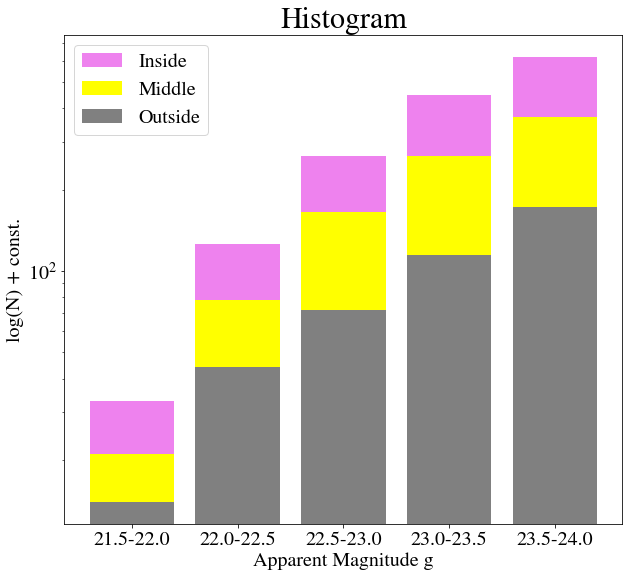

In [42]:
x_data = df_tbl3.index

y_global = np.cumsum(df_tbl3['Global']['N'] / df_tbl3['Global']['f'])
y_in = np.cumsum(df_tbl3['Inside']['N'] / df_tbl3['Inside']['f'])
y_mid = np.cumsum(df_tbl3['Middle']['N'] / df_tbl3['Middle']['f'])
y_out = np.cumsum(df_tbl3['Outside']['N'] / df_tbl3['Outside']['f'])

fig, ax = plt.subplots(figsize=(10,9))


ax.bar(x_data, y_in, label='Inside', color='violet')
ax.bar(x_data, y_mid, label='Middle', color='yellow')
ax.bar(x_data, y_out, label='Outside', color='grey')
ax.set_title('Histogram')
ax.set_yscale('log')
ax.set_ylabel('log(N) + const.')
ax.set_xlabel('Apparent Magnitude g')
ax.legend();

Text(0.5, 0, 'Apparent Magnitude g')

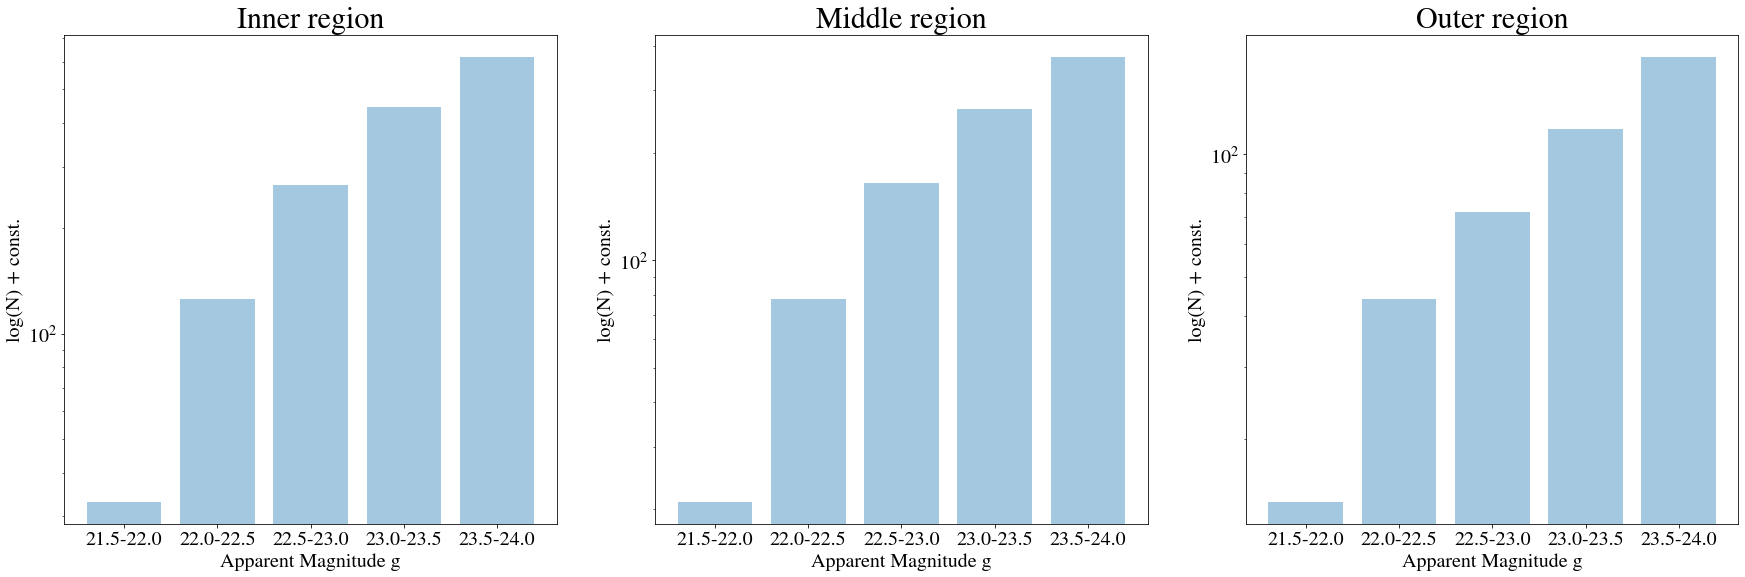

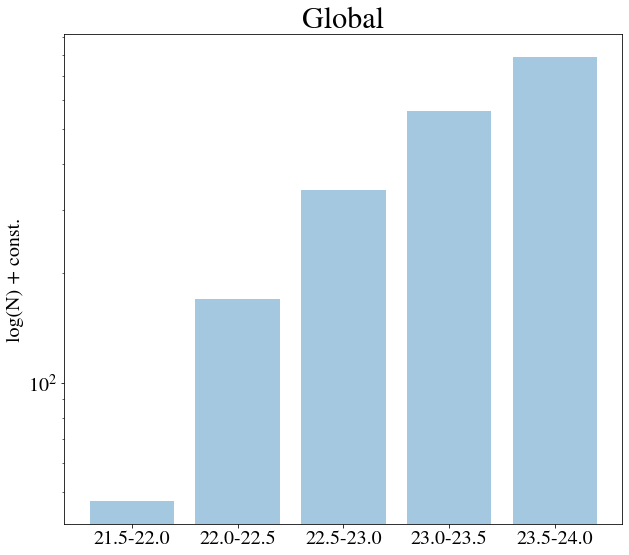

In [43]:
x_data = df_tbl3.index

y_global = np.cumsum(df_tbl3['Global']['N'] / df_tbl3['Global']['f'])
y_in = np.cumsum(df_tbl3['Inside']['N'] / df_tbl3['Inside']['f'])
y_mid = np.cumsum(df_tbl3['Middle']['N'] / df_tbl3['Middle']['f'])
y_out = np.cumsum(df_tbl3['Outside']['N'] / df_tbl3['Outside']['f'])

fig, axs = plt.subplots(1, 3, figsize=(30,9))


axs[0].bar(x_data, y_in, label='Inside', alpha=0.4)
axs[0].set_title('Inner region')
axs[1].bar(x_data, y_mid, label='Middle', alpha=0.4)
axs[1].set_title('Middle region')
axs[2].bar(x_data, y_out, label='Outside', alpha=0.4)
axs[2].set_title('Outer region')

for i in range(3):
    axs[i].set_yscale('log')
    axs[i].set_ylabel('log(N) + const.')
    axs[i].set_xlabel('Apparent Magnitude g')

fig2, ax = plt.subplots(figsize=(10,9))

ax.bar(x_data, y_global, label='Global', alpha=0.4)
ax.set_title('Global')
ax.set_yscale('log')
ax.set_ylabel('log(N) + const.')
axs[i].set_xlabel('Apparent Magnitude g')

#### Figure 8

To obtain the mass as a function of the luminosity, we go back to looking at the isochrone. These dataframes contains a row for mass!

The first thing that will be done is to add the correction constant that was used to plot the isochrone with our CMD.

The first approach to create a mass luminosity function from the isochrone will be done using splines froms ``scipy``

In [44]:
from scipy.interpolate import CubicSpline

In [45]:
df_iso = df_iso13.copy()
df_iso

,#EEP,M/Mo,LogTeff,LogG,LogL/Lo,sdss_u,sdss_g,sdss_r,sdss_i,sdss_z,g-r
0,13,0.100632,3.5455,5.4029,-2.8266,17.8696,13.9887,12.3298,11.6536,11.2848,1.6589
1,14,0.110095,3.5569,5.3595,-2.6992,17.0698,13.5504,11.9622,11.3402,10.9928,1.5882
2,15,0.120113,3.5682,5.3159,-2.5725,16.3233,13.1063,11.6015,11.0242,10.6963,1.5048
3,16,0.130785,3.5786,5.2742,-2.4522,15.6474,12.6866,11.2671,10.7236,10.4114,1.4195
4,17,0.141602,3.5870,5.2379,-2.3476,15.0592,12.3215,10.9806,10.4621,10.1622,1.3409
...,...,...,...,...,...,...,...,...,...,...,...
262,275,0.789149,3.6545,0.7862,3.1200,0.1538,-1.8966,-2.8591,-3.2325,-3.4392,0.9625
263,276,0.789154,3.6530,0.7553,3.1454,0.1453,-1.9378,-2.9154,-3.2945,-3.5046,0.9776
264,277,0.789159,3.6517,0.7254,3.1701,0.1382,-1.9772,-2.9698,-3.3547,-3.5680,0.9926
265,278,0.789163,3.6505,0.6968,3.1937,0.1316,-2.0148,-3.0218,-3.4123,-3.6287,1.0070


In [46]:
df_iso_filt = df_iso.loc[df_iso.sdss_g > 3.8]

x = df_iso['sdss_g'][::-1]
y = df_iso['M/Mo'][::-1]

spline = CubicSpline(x, y, bc_type='natural')
spline_inv = CubicSpline(y[::-1], x[::-1], bc_type='natural')
spline2 = CubicSpline(x, y, bc_type='clamped')
spline3 = CubicSpline(x, y, bc_type='not-a-knot')

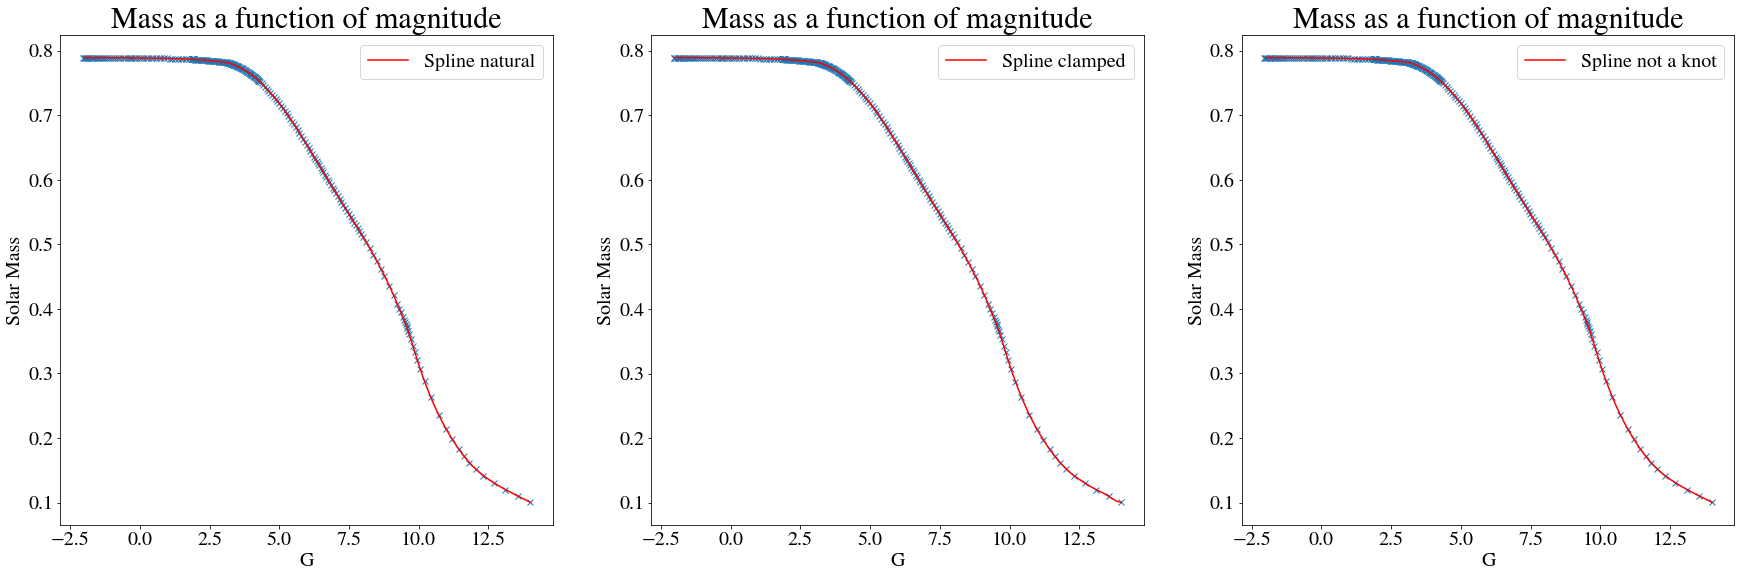

In [47]:
x_to_plot = np.linspace(-2, 14, 100)

x_data = df_iso['sdss_g']
y_data = df_iso['M/Mo']

fig, axs = plt.subplots(1, 3, figsize=(30,9))

axs[0].plot(x_data, y_data, 'x')
axs[1].plot(x_data, y_data, 'x')
axs[2].plot(x_data, y_data, 'x')
axs[0].plot(x_to_plot, spline(x_to_plot), label='Spline natural', c='r')
axs[1].plot(x_to_plot, spline2(x_to_plot), label='Spline clamped', c='r')
axs[2].plot(x_to_plot, spline3(x_to_plot), label='Spline not a knot', c='r')
for ax in axs:
    ax.set_xlabel('G')
    ax.set_ylabel('Solar Mass')
    ax.set_title('Mass as a function of magnitude')
    ax.legend();

In [48]:
df_filt_stars.insert(df_filt_stars.shape[1], 'M/Mo', df_filt_stars.G.apply(spline), True)

---

Now, a similar table to the one obtained previously is constructed, but this one will contain mass.

In [49]:
mass_bins = np.linspace(df_filt_stars['M/Mo'].min(), df_filt_stars['M/Mo'].max(), 5)

N_in = np.zeros(len(mass_bins[:-1]), dtype=int)
N_mid = np.zeros(len(mass_bins[:-1]), dtype=int)
N_out = np.zeros(len(mass_bins[:-1]), dtype=int)


for idx, mass in enumerate(mass_bins[:-1]):
    low, up = mass, mass_bins[idx + 1]
    mask = (df_filt_stars['M/Mo'] >= low) & (df_filt_stars['M/Mo'] < up)
    N_in[idx] += len(df_filt_stars.loc[mask & (df_filt_stars.rd <= 6)])
    N_mid[idx] += len(df_filt_stars.loc[mask & ((df_filt_stars.rd > 6) & (df_filt_stars.rd <= 12))])
    N_out[idx] += len(df_filt_stars.loc[mask & (df_filt_stars.rd > 6)])

In [50]:
mass_bins_str = []

for idx in range(len(mass_bins) - 1):
    str_mass = str(round(mass_bins[idx], 3))
    str_mass1 = str(round(mass_bins[idx + 1], 3))
    mass_bins_str.append(str_mass+'-'+str_mass1)

In [51]:
columns = ['N inside','N middle', 'N outside', 'N global']

In [52]:
data_in = np.array(N_in, dtype='float')
data_mid = np.array(N_mid, dtype='float')
data_out = np.array(N_out, dtype='float')
data_gen = np.array(N_in + N_out, dtype='float')

In [53]:
df_mass = pd.DataFrame(data={'N inside': data_in,'N middle': data_mid, 'N outside': data_out, 'N global': data_gen},
                        columns=columns, index=mass_bins_str)
df_mass.index.name = 'Mass'

In [54]:
df_mass

,N inside,N middle,N outside,N global
Mass,,,,
0.633-0.667,70.0,55.0,81.0,151.0
0.667-0.701,102.0,49.0,81.0,183.0
0.701-0.735,91.0,58.0,71.0,162.0
0.735-0.769,83.0,52.0,81.0,164.0


Add column with absolute magnitudes

In [55]:
mag_bins_str = []

for idx in range(len(mass_bins) - 1):
    str_mag = str(round(float(spline_inv(mass_bins[idx])), 3))
    str_mag1 = str(round(float(spline_inv(mass_bins[idx + 1])), 3))
    mag_bins_str.append(str_mag+'-'+str_mag1)

df_mass.insert(0, 'G', mag_bins_str)

In [56]:
df_mass

,G,N inside,N middle,N outside,N global
Mass,,,,,
0.633-0.667,6.282-5.806,70.0,55.0,81.0,151.0
0.667-0.701,5.806-5.296,102.0,49.0,81.0,183.0
0.701-0.735,5.296-4.684,91.0,58.0,71.0,162.0
0.735-0.769,4.684-3.805,83.0,52.0,81.0,164.0


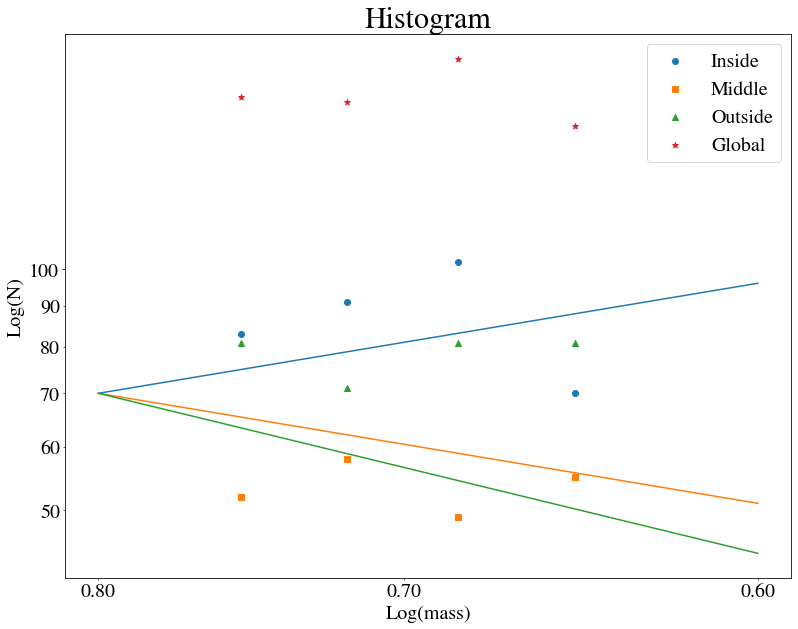

In [57]:
masses = np.linspace(0.6, 0.8, 100)
x = np.array([1.1, -1.1, -1.6])
k = -70 * x / (0.8**(-x))
step = (mass_bins[1] - mass_bins[0]) / 2

fig, ax = plt.subplots(figsize=(13, 10))



ax.set_yscale('log')
ax.set_xscale('log')

ax.xaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.scatter(mass_bins[:-1] + step, df_mass['N inside'], label='Inside')
ax.scatter(mass_bins[:-1] + step, df_mass['N middle'], marker='s', label='Middle')
ax.scatter(mass_bins[:-1] + step, df_mass['N outside'], marker='^', label='Outside')
ax.scatter(mass_bins[:-1] + step, df_mass['N global'], marker='*', label='Global')

for i in range(3):
    ax.plot(masses, k[i]*(masses**(-x[i])/(-x[i])))

ax.set_xlabel('Log(mass)')
ax.set_ylabel('Log(N)')
# ax.set_xticks(mass_bins[:-1] + step)
ax.set_title('Histogram')
ax.set_xlim(ax.get_xlim()[::-1])
ax.legend();